# Summary
This assignment is the final step in preparation for the term project. It involves developing a closed-loop controller for the system model developed in HW 0x02: System Modeling and HW 0x04: Linearization and Simulation of System Model. The code for this assignment is written in Python3 within a Jupyter notebook.

# Setup
The code in this section is copied over from HW 0x04 and is required to complete this assignment. See the HW 0x04 module for more details and documentation. There is a trivial change to the `system_eq()` function, which now takes the gain matrix $K$ as an input parameter. Work for HW 0x05: Full State Feedback (Pole Placement) begins in the section labeled Pole Placement below. 

In [1]:
from sympy import *
from matplotlib import pyplot as plot
from scipy.integrate import solve_ivp

x, x_dot, theta, theta_dot, T_m = symbols("x v theta omega T_m")

r_m = 60e-3    # Radius of Lever Arm [m]
l_r = 50e-3    # Length of Push Rod [m]
r_b = 10.5e-3  # Radius of Ball [m]
r_g = 42e-3    # Vertical Distance from U-Joint to CG of Platform [m]
l_p = 110e-3   # Horizontal Distance from U-Joint to Push-Rod Pivot [m]
r_p = 32.5e-3  # Vertical Distance from U-Joint to Push-Rod Pivot [m]
r_c = 50e-3    # Vertical Distance from U-Joint to Platform Surface [m]
m_b = 30e-3    # Mass of Ball [kg]
m_p = 400e-3   # Mass of Platform [kg]
I_p = 1.88e-3  # Moment of Inertia of Platform [kg m^2]
b   = 10e-3    # Viscous friction at U-Joint [N m s / rad]
I_b = (2/5)*m_b*r_b**2 # Inertia of the ball [kg m^2]

g = 9.81  # Gravity [m / s^2]

M11 = -m_b*r_b - m_b*r_c - I_b/r_b
M12 = -m_b*r_b**2 - 2*m_b*r_b*r_c - m_b*r_c**2 - m_p*r_g**2 - m_b*x**2 - I_b - I_p
M21 = -m_b*r_b - I_b/r_b
M22 = -m_b*r_b**2 - m_b*r_b*r_c - I_b

M = Matrix([[M11, M12], 
            [M21, M22]])

# Acceleration of ball
f1 = -g*m_b*r_b*sin(theta) - g*m_p*r_g*sin(theta) - g*m_b*r_c*sin(theta) - g*m_b*x*cos(theta) + T_m*l_p/r_m + b*theta_dot + 2*m_b*theta_dot*x*x_dot- m_b*r_b*theta_dot**2*x
# Acceleration of plate
f2 = -m_b*r_b*(x*theta_dot**2 + g*sin(theta))

f = Matrix([[f1], 
            [f2]])

q = M.inv() * f

A11 = diff(q[0], x)           # Acceleration of ball WRT ball position
A12 = diff(q[0], theta)       # Acceleration of ball WRT platform position
A13 = diff(q[0], x_dot)       # Acceleration of ball WRT ball velocity
A14 = diff(q[0], theta_dot)   # Acceleration of ball WRT platform velocity
A21 = diff(q[1], x)           # Acceleration of platform WRT ball position
A22 = diff(q[1], theta)       # Acceleration of platform WRT platform position
A23 = diff(q[1], x_dot)       # Acceleration of platform WRT ball velocity
A24 = diff(q[1], theta_dot)   # Acceleration of platform WRT platform velocity

A = Matrix([[  0,   0,   1,   0], 
            [  0,   0,   0,   1], 
            [A11, A12, A13, A14], 
            [A21, A22, A23, A24]])

B = Matrix([[0              ], 
            [0              ], 
            [diff(q[0], T_m)],   # Acceleration of ball WRT motor torque
            [diff(q[1], T_m)]])  # Acceleration of platform WRT motor torque

def system_eq(states, K, loop = 'closed'):    
    states = Matrix([[states[0]], 
                     [states[1]], 
                     [states[2]], 
                     [states[3]]])
    # K = Matrix([[-12.844, -5.179, -4.465, -0.326]])
    u = 0 if loop == 'open' else -K * states
    x = A*states + B*u
    return [x[0], x[1], x[2], x[3]]

def graph(results):
    # Show 4 subplots
    fig, ax = plot.subplots(2, 2, figsize = (20, 10))
    
    ax[0, 0].plot(results.t, results.y[0])
    ax[0, 0].set_ylabel('Position $\mathit{x}$ [m]')
    ax[0, 0].set_title('Position Response of Ball')
    
    ax[0, 1].plot(results.t, results.y[1])
    ax[0, 1].set_ylabel('Angular Position $\mathit{θ_p}$ [rad]')
    ax[0, 1].set_title('Position Response of Platform')
    
    ax[1, 0].plot(results.t, results.y[2])
    ax[1, 0].set_ylabel('Velocity $\mathit{\dot{x}}$ [m/s]')
    ax[1, 0].set_title('Velocity Response of Ball')                 
    
    ax[1, 1].plot(results.t, results.y[3])
    ax[1, 1].set_ylabel('Angular Velocity $\mathit{\dot{θ_p}}$ [rad/s]')
    ax[1, 1].set_title('Velocity Response of Platform')

    for row in range(len(ax)):
        for col in range(len(ax)):
            ax[row, col].grid(True, alpha = 0.5)
            ax[row, col].tick_params(direction = 'in')
            ax[row, col].set_xlim(xmin = 0)
            ax[row, col].set_xlabel('Time $\mathit{t}$ [s]')

    plot.show()

In [2]:
A = A.subs({x: 0, theta: 0, x_dot: 0, theta_dot: 0, T_m: 0})
print('A = ')
A

A = 


Matrix([
[                0,                0, 1,                 0],
[                0,                0, 0,                 1],
[-5.21699855336124, 4.01109511649826, 0, 0.177268044626614],
[ 112.887140258203, 64.8294719768538, 0, -3.83578458233786]])

In [3]:
B = B.subs({x: 0, theta: 0, x_dot: 0, theta_dot: 0, T_m: 0})
print('B = ')
B

B = 


Matrix([
[                0],
[                0],
[ 32.4991415148792],
[-703.227173428607]])

# Pole Placement
The values for the system state matrix $A$ and the input matrix $B$ after linearization were determined in HW 0x04. They have been redeclared below as the 2D-lists `A1` and `B1` for compatibility with the `matlab.place()` function. 

The `control` module in Python imports the Python Control Systems Toolbox, which is a set of python classes and functions that implements common operations for the analysis and design of feedback control systems. The `matlab` submodule within `control` contains functions to emulate some of the functionality of MATLAB. Note: users may have to run `pip install control` to install the `control` module, as it is not included in the Anaconda Python package.

To determine pole locations, an arbitrary natural frequency $\omega_n = 10$ and damping ratio $\zeta = 0.95$ were chosen, along with two other large poles. These values should lead to the system returning to equilibrium within 1 second. In other words, the criteria for selecting these poles is to achieve a settling time of 1 second or less. Handwritten calculations used to find these poles has been included.

Since the poles $\lambda_3$ and $\lambda_4$ are 10x larger than $\lambda_1$ and $\lambda_2$ associated with $\omega_n$ and $\zeta$, the system behaves like a second-order system. As shown below, the `matlab.place()` function confirms that the handwritten work is correct.

In [4]:
from control import matlab

A1 = [[ 0,       0,       1,       0        ],
      [ 0,       0,       0,       1        ],
      [-5.217,   4.011,   0,       0.177    ],
      [ 112.887, 64.829,  0,      -3.836    ]]

B1 = [[0       ],
      [0       ],
      [32.499  ],
      [-703.227]]

wn = 10
zeta = 0.95
p1 = complex(-wn*zeta, wn*((1 - zeta**2)**0.5))
p2 = complex(-wn*zeta, -wn*((1 - zeta**2)**0.5))

p = [p1, p2, 10*p1, 10*p2]

K = matlab.place(A1, B1, p)
print('K = ', K)

K =  [[-203.10220296  -28.97855503  -42.42285661   -2.25228044]]


# Results
The response of each system variable is shown below for different cases. The plots are generated using the `solve_ivp()` function from the `integrate` package within the `scipy` Python library. This function solves an initial value problem for a system of ODEs given the model returned by `system_eq()`, integrated over the interval `time` and given the initial `states`.

# Case 1
The ball is initially at rest on a level platform offset horizontally from the center of gravity of the platform by 5$[cm]$ and there is no torque input from the motor. This simulation has been run for 1.5$[s]$.

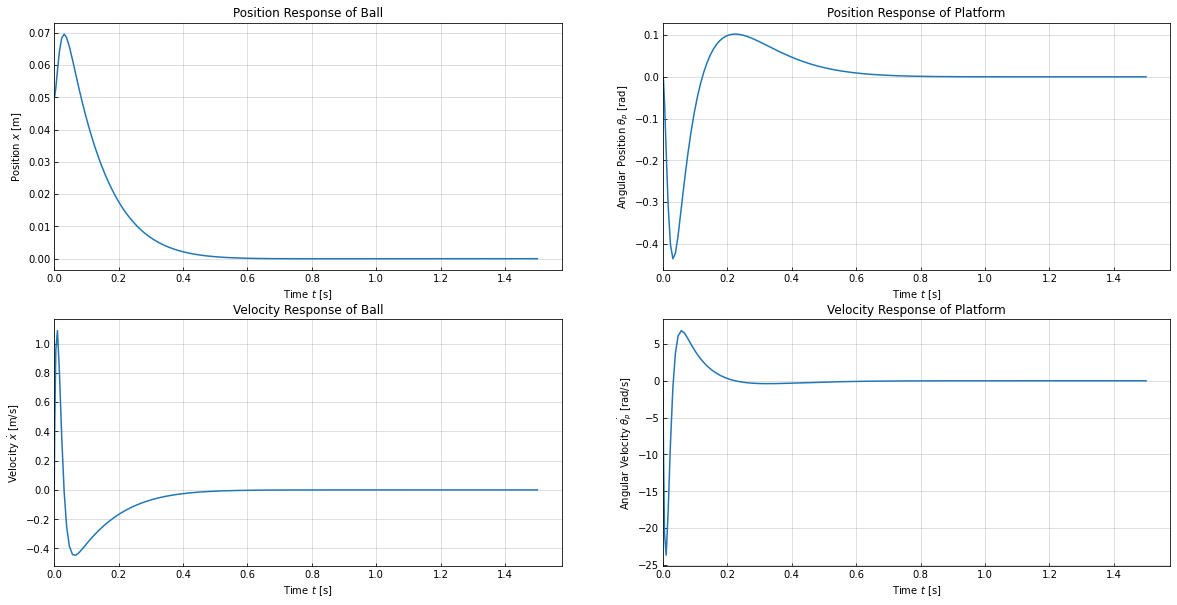

In [5]:
graph(solve_ivp(lambda time, states: system_eq(states, K), 
                                     [0.0, 1.5],           # simulation time
                                     [5e-2, 0, 0, 0],      # initial conditions
                                     max_step = 0.01))

# Conclusion
Compared to the response using the gains from HW 0x04, the new gain matrix returns to a stable state much quicker, with all system variables returning to equilibrium within 0.75s. This achieves the selected criteria of returning to stability within 1s for each system variable.

# Appendix
Handwritten work is included here:
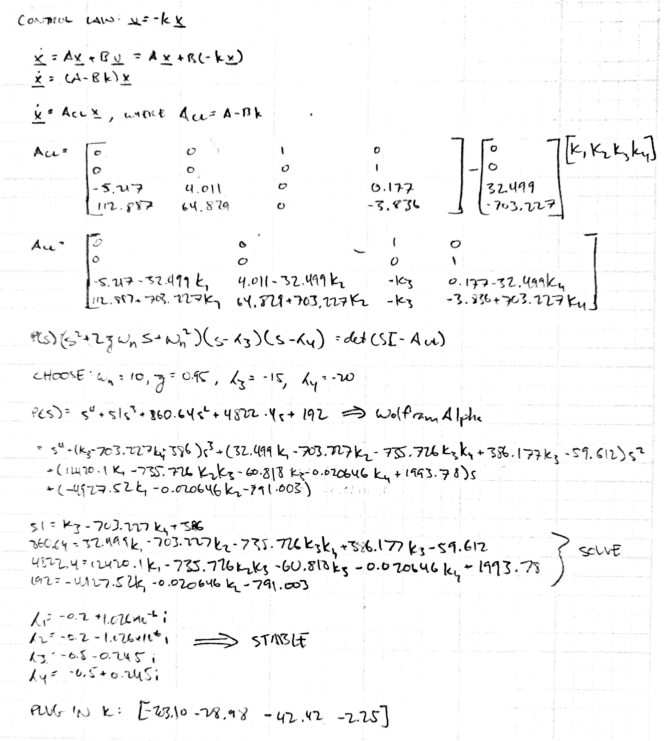